In [1]:
#!/usr/bin/env python3
"""
Neven Caplar 
Last updated: 2023-10-07

Goals: 
Fit the data

Each Section can/should run independently,
only these initial imports should be shared among all sections

Questions:
What determines memory limit of the workers
How to partition the dataframe in order to get more workers active
s

"""
import numpy as np
import pandas as pd
import pyarrow as pa

# from scipy.spatial import KDTree
import matplotlib.pyplot as plt

import celerite
from celerite import terms
from celerite.modeling import Model
from celerite.solver import get_kernel_value

import scipy.optimize as sco
import numpy as np
import pickle
import cloudpickle

from tqdm import tqdm

import time

import matplotlib.pyplot as plt

from tape.ensemble import Ensemble
from tape.utils import ColumnMapper


import warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def print_series(s):
    print("Pandas Series")
    for k, v in s.items():
        print(f"{k}: {v}")

In [2]:
import dask
# many workers
# dask.config.set(scheduler='threads') 

# does not work
# from multiprocessing.pool import ThreadPool
# dask.config.set(pool=ThreadPool(20))

# one worker
# dask.config.set(scheduler='processes')  
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
# cluster.adapt(minimum=10, maximum=40) 

/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32768 instead
  warnings.warn(


In [3]:
ens = Ensemble(client = client)  # initialize an ensemble object
ens.client_info()


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:32768/status,
Dashboard: http://127.0.0.1:32768/status,Workers: 8
Total threads: 64,Total memory: 251.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37130,Workers: 8
Dashboard: http://127.0.0.1:32768/status,Total threads: 64
Started: Just now,Total memory: 251.68 GiB
Comm: tcp://127.0.0.1:38225,Total threads: 8
Dashboard: http://127.0.0.1:42891/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:40770,


In [4]:
# Tape Single Pixel - real data 

# Tape Single Pixel - real data 

In [5]:
# if running on baldur
data_path = "/astro/store/epyc/data3/hipscat/catalogs/tape_test/"

col_map = ColumnMapper(id_col="SDSS_NAME_dr16q_constant", 
                       time_col="mjd_ztf_source",
                       flux_col="mag_ztf_source", 
                       err_col="magerr_ztf_source",
                       band_col="band_ztf_source")

ens.from_hipscat(data_path,
                 source_subdir="tape_test_sources",
                 object_subdir="tape_test_obj",
                 column_mapper=col_map,
                 additional_cols=True,
                 sync_tables=False,
                 sort=False,
                 )

/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [6]:
ens.query("band_ztf_source == 'g'", table = 'source')
ens.prune(10)
ens.query("rMeanPSFMag_ps1_otmo < 20", table = 'object')

In [7]:
ens_nobs = ens.calc_nobs(temporary=False)

(17.0, 21.0)

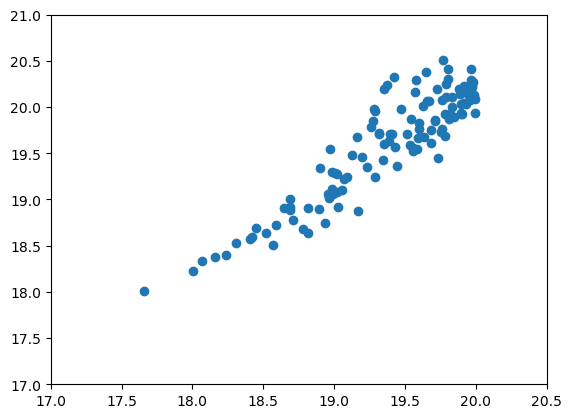

In [8]:
plt.scatter(ens._object['rMeanPSFMag_ps1_otmo'].compute().values, ens._object['gMeanPSFMag_ps1_otmo'].compute().values)
plt.xlim(17,20.5)
plt.ylim(17,21)

(17.0, 23.0)

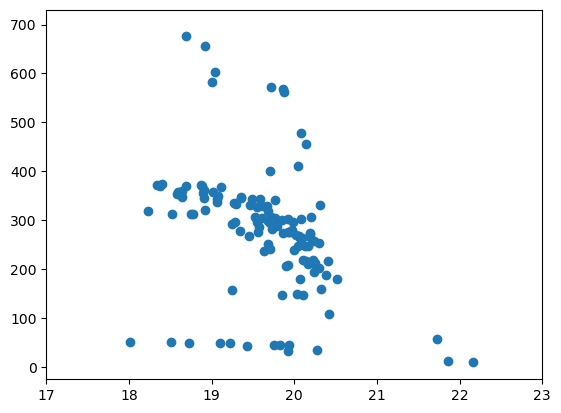

In [9]:
plt.scatter( ens._object['gMeanPSFMag_ps1_otmo'].compute().values,ens_nobs._object['nobs_total'].compute().values)
plt.xlim(17,23)

(array([ 4.,  9.,  4.,  0.,  1.,  0.,  2.,  3.,  3.,  4.,  7.,  6.,  8.,
        13., 14.,  7., 17.,  7.,  6.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
         0.,  2.,  2.,  1.,  0.,  0.,  1.,  1.,  1.]),
 array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150., 170., 190., 210.,
        230., 250., 270., 290., 310., 330., 350., 370., 390., 410., 430.,
        450., 470., 490., 510., 530., 550., 570., 590., 610., 630., 650.,
        670., 690., 710.]),
 <BarContainer object of 35 artists>)

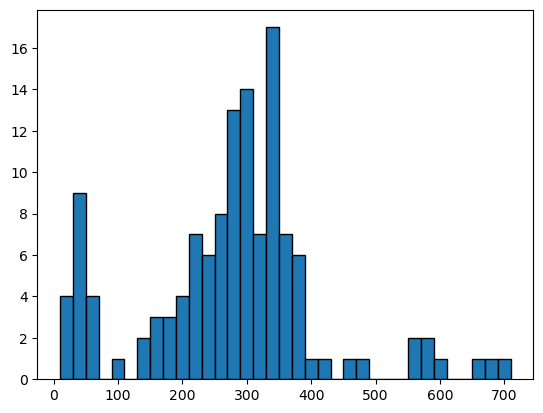

In [10]:

data = ens_nobs._object['nobs_total'].compute().values

bin_edges = range(min(data), max(data) + 21, 20) 
plt.hist(data, bins=bin_edges, edgecolor='k')  # 'k' sets black color for edges


# Setup for Celerite

In [11]:
bad_value = np.inf

In [12]:
class CustomTerm_drw(terms.Term):
    parameter_names = ("log_drw_scale", "log_drw_amp")

    def get_real_coefficients(self, params):
        log_drw_scale, log_drw_amp = params
        #print('log_drw_scale: %f' % log_per_scale)
        # print('log_drw_amp: %f' % log_per_amp)
        # transform from tinygp convention to celerite convention
        drw_scale_cel =  (10**(-log_drw_scale))
        drw_amp_cel =(10**log_drw_amp)**2

        return (
            drw_amp_cel, drw_scale_cel
        )
        
class CustomTerm_per(terms.Term):
    parameter_names = ("log_per_scale", "log_per_amp")

    def get_complex_coefficients(self, params):
        log_per_scale, log_per_amp = params
        # print('log_per_scale: %f' % log_per_scale)
        # print('log_per_amp: %f' % log_per_amp)
        per_scale_cel = 2*np.pi/10**(log_per_scale)
        per_amp_cel = (10**log_per_amp)**2
        
        return (
            per_amp_cel, 0.0,
            0, per_scale_cel,
        )
        
        
class CustomTerm(terms.Term):
    parameter_names = ("log_drw_scale", "log_drw_amp", "log_per_scale", "log_per_amp")
    
    # Expected bounds: amplitude should never be negative, so hesitant to specify bounds

    def get_real_coefficients(self, params):
        log_drw_scale, log_drw_amp, log_per_scale, log_per_amp = params
        #print('log_drw_scale: %f' % log_per_scale)
        # print('log_drw_amp: %f' % log_per_amp)
        # transform from tinygp convention to celerite convention
        drw_scale_cel =  (10**(-log_drw_scale))
        drw_amp_cel =(10**log_drw_amp)**2

        return (
            drw_amp_cel, drw_scale_cel
        )

    def get_complex_coefficients(self, params):
        log_drw_scale, log_drw_amp, log_per_scale, log_per_amp = params
        # print('log_per_scale: %f' % log_per_scale)
        # print('log_per_amp: %f' % log_per_amp)
        # periodic scale
        per_scale_cel = 2*np.pi/10**(log_per_scale)
        # periodic amplitude
        per_amp_cel = (10**log_per_amp)**2
        
        return (
            per_amp_cel, 0.0,
            0, per_scale_cel,
        )
    
def create_theta_init(n=1):
    """Create alternative initializations for the optimization.

    Parameters
    ----------
    n : int, optional
        The number of alternative theta initializations to create.
        If `n` is not provided, the default value is set to 1.

    Returns
    -------
    alt_theta_init : ndarray
        Array containing alternative theta initializations.
    """
    # TODO consider seed
    np.random.seed(42)
    # TODO(wbeebe@uw.edu): Minor speedup by avoiding need to transpose?
    theta_init = np.array([np.random.uniform(0, 5, n),
                                np.random.uniform(-3, 2, n),
                                np.random.uniform(0, 5, n),
                                np.random.uniform(-3, -0.25, n)])
    return theta_init.transpose()

def create_kernel(use_combined, theta_init):
    log_drw_scale = theta_init[0]
    log_drw_amp = theta_init[1]
    log_per_scale = theta_init[2]
    log_per_amp = theta_init[3]
    if use_combined:
        return CustomTerm(log_drw_amp=log_drw_amp, log_drw_scale=log_drw_scale,
                    log_per_amp=log_per_amp, log_per_scale=log_per_scale)
    return CustomTerm_drw(log_drw_amp=log_drw_amp, log_drw_scale=log_drw_scale)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def soln_cel_ty_iter(t, y, yerr, use_combined, theta_init):
    param_size = 4 if use_combined else 2
    kernel = create_kernel(use_combined, theta_init)
    # TODO(wbeebe@uw.edu) remove try-except when linear algebra errors are fixed
    try:
        gp = celerite.GP(kernel, mean=np.mean(y))
        gp.compute(t, yerr)
    except Exception as e:
        warnings.warn("Failed to minimize.\n" + str(e))
        # Return a known "invalid" value to filter out
        return np.inf, np.full(param_size, np.inf), theta_init 

    # TODO(wbeebe@uw.edu): is this always the same as theta_init
    initial_params = gp.get_parameter_vector()
    #bounds = gp.get_parameter_bounds()
    # TODO(wbeebe@uw.edu) remove try-except when linear algebra errors are fixed
    try:
        # TODO(wbeebe@uw.edu): L-BFGS-B seems to result in less errors
        soln_celerite = sco.minimize(neg_log_like, x0=initial_params, method="bfgs", args=(y, gp))
        #soln_celerite = sco.minimize(neg_log_like, x0=initial_params, method="L-BFGS-B", args=(y, gp))
        #soln_celerite = sco.minimize(neg_log_like, x0 = initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))       
    except Exception as e:
        warnings.warn("Failed to minimize.\n" + str(e))
        # Return a known "invalid" value to filter out
        return np.inf, np.full(param_size, np.inf),  initial_params

    return soln_celerite.fun, soln_celerite.x, initial_params

def soln_cel_ty(t, y, yerr, use_combined=True, iter=1, verbose=False):
    # Celerite requires the lightcurve data to be sorted by time.
    sorted_indices = np.argsort(t)

    # Use these indices to sort y and yerr
    t = t[sorted_indices]
    y = y[sorted_indices]
    yerr = yerr[sorted_indices]

    param_size = 4 if use_combined else 2

    theta_init = create_theta_init(iter)
    min_likelihood = np.inf
    best_params = np.full(param_size, np.inf)
    best_init_params = np.full(param_size, np.inf)
    cnt = 1
    for theta in theta_init:
        if verbose:
            print(f"running iteration {cnt} out of {iter} iterations ")
            print(f"Current parameters: {theta}")
        cnt += 1
        likelihood, params, init_params = soln_cel_ty_iter(t, y, yerr, use_combined, theta)
        if likelihood < min_likelihood:
            min_likelihood = likelihood
            best_params = params
            best_init_params = init_params
    return np.concatenate((np.full(1, min_likelihood), best_params, best_init_params),axis=None)

In [13]:
ens._object.head(1)

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,yMeanPSFMag_ps1_otmo,yMeanPSFMagErr_ps1_otmo,yFlags_ps1_otmo,Norder_ps1_otmo,Dir_ps1_otmo,Npix_ps1_otmo,_DIST,Norder,Dir,nobs_total
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,19.193501,0.039844,115000,5,0,4438,0.000016,5,0,252


In [14]:
sample_lc = ens._source.compute().loc[b'024341.05-010243.3']
sample_lc

,_hipscat_index,PLATE_dr16q_constant,MJD_dr16q_constant,FIBERID_dr16q_constant,RA_dr16q_constant,DEC_dr16q_constant,OBJID_dr16q_constant,IF_BOSS_SDSS_dr16q_constant,Z_DR16Q_dr16q_constant,SOURCE_Z_DR16Q_dr16q_constant,...,kronFluxErr_ps_source,infoFlag_ps_source,infoFlag2_ps_source,infoFlag3_ps_source,Norder_ps_source,Dir_ps_source,Npix_ps_source,Norder,Dir,provenance
SDSS_NAME_dr16q_constant,,,,,,,,,,,,,,,,,,,,,
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1
b'024341.05-010243.3',4996749735944519680,4240,55455,178,40.921044,-1.045386,b'4240-55455-0178',b'BOSS',2.369,b'VI',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,10000,survey_1


In [15]:
soln_cel_ty(sample_lc["mjd_ztf_source"], sample_lc["mag_ztf_source"], sample_lc["magerr_ztf_source"], use_combined=True, iter=100, verbose=False)

/tmp/ipykernel_37226/598693461.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t = t[sorted_indices]
/tmp/ipykernel_37226/598693461.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y[sorted_indices]
/tmp/ipykernel_37226/598693461.py:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yerr = yerr[sorted_indices]
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
 

array([-156.84161744,   -0.33744834,   -1.06479081,    3.12391142,
         -1.23699372,    4.69749471,   -2.27552564,    4.25568336,
         -1.18859251])

In [16]:
soln_cel_ty(sample_lc["mjd_ztf_source"], sample_lc["mag_ztf_source"], sample_lc["magerr_ztf_source"], use_combined=False, iter=2)

/tmp/ipykernel_37226/598693461.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t = t[sorted_indices]
/tmp/ipykernel_37226/598693461.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y[sorted_indices]
/tmp/ipykernel_37226/598693461.py:135: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yerr = yerr[sorted_indices]


array([-1.46283539e+02,  6.03997459e-01, -9.90686917e-01,  4.75357153e+00,
       -6.70757901e-03])

In [17]:

# TODO fix applying celerite meta, so we return a dataframe rather than a nested array

res_cel = ens.batch(soln_cel_ty, "mjd_ztf_source", "mag_ztf_source", "magerr_ztf_source",
                compute=True, use_combined=True, iter=100)
"""
test_meta = ["sol_param1", "sol_param2","sol_param3", "sol_param4", "likelihood"]

pd.DataFrame(
    columns=["sol_param1", "sol_param2","sol_param3", "sol_param4", "likelihood"],
    dtype="float64",
    #index=pd.Series(name="SDSS_NAME_dr16q_constant", dtype="object"),
)

celerite_meta = pd.DataFrame(
    columns=["sol_param1", "sol_param2","sol_param3", "sol_param4", "likelihood"],
    dtype="float64",
    index=pd.Series(name="SDSS_NAME_dr16q_constant", dtype="object"),
)

celerite_meta = {"SDSS_NAME_dr16q_constant": int, "sol_param1": float, "sol_param2": float, "sol_param4": float, "sol_param4": float, "likelihood": float}
celerite_drw_meta = {"SDSS_NAME_dr16q_constant": int, "sol_param1": float, "sol_param2": float, "likelihood": float}
celerite_meta

init_res_cel = ens.batch(soln_cel_ty, "mjd_ztf_source", "mag_ztf_source", "magerr_ztf_source",
                compute=True, meta=test_meta, use_combined=True, iter=1)
"""


/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_37226/598693461.py:54: RuntimeWarnin

'\ntest_meta = ["sol_param1", "sol_param2","sol_param3", "sol_param4", "likelihood"]\n\npd.DataFrame(\n    columns=["sol_param1", "sol_param2","sol_param3", "sol_param4", "likelihood"],\n    dtype="float64",\n    #index=pd.Series(name="SDSS_NAME_dr16q_constant", dtype="object"),\n)\n\ncelerite_meta = pd.DataFrame(\n    columns=["sol_param1", "sol_param2","sol_param3", "sol_param4", "likelihood"],\n    dtype="float64",\n    index=pd.Series(name="SDSS_NAME_dr16q_constant", dtype="object"),\n)\n\ncelerite_meta = {"SDSS_NAME_dr16q_constant": int, "sol_param1": float, "sol_param2": float, "sol_param4": float, "sol_param4": float, "likelihood": float}\ncelerite_drw_meta = {"SDSS_NAME_dr16q_constant": int, "sol_param1": float, "sol_param2": float, "likelihood": float}\ncelerite_meta\n\ninit_res_cel = ens.batch(soln_cel_ty, "mjd_ztf_source", "mag_ztf_source", "magerr_ztf_source",\n                compute=True, meta=test_meta, use_combined=True, iter=1)\n'

In [18]:
res_cel

SDSS_NAME_dr16q_constant
b'024050.36-003109.0'    [-42.51997531403728, 2.344152911777488, -0.666...
b'024052.82-004110.9'    [-73.97676144135617, 1.0420969698836644, -1.09...
b'024126.71-004526.3'    [-84.60632999064606, 1.0917750056958955, -1.52...
b'024151.76-001953.6'    [-181.485998474192, 0.9062121837925955, -0.869...
b'024154.42-004757.6'    [-51.03641952425785, 1.6182612345348903, -1.49...
                                               ...                        
b'024419.10+005539.2'    [-229.74624506847363, 0.2844258574115477, -0.9...
b'024448.90+002858.6'    [-203.28000427087767, 0.6940140405313533, -0.8...
b'024504.47+002841.3'    [-112.52212774827137, 1.7871043755727272, -0.7...
b'024508.67+003710.6'    [-77.64659908844618, 0.6492384453217898, -0.75...
b'024514.80+003923.3'    [7.6874616926580615, 0.25404913363637854, -0.7...
Name: SDSS_NAME_dr16q_constant, Length: 127, dtype: object

In [19]:
drw_cel = ens.batch(soln_cel_ty, "mjd_ztf_source", "mag_ztf_source", "magerr_ztf_source",
                compute=True, use_combined=False, iter=100)

/tmp/ipykernel_37226/598693461.py:10: RuntimeWarning: overflow encountered in double_scalars
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_37226/598693461.py:10: RuntimeWarning: overflow encountered in double_scalars
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_37226/598693461.py:122: UserWarning: Failed to minimize.
failed to factorize or solve matrix
/tmp/ipykernel_37226/598693461.py:10: RuntimeWarning: overflow encountered in double_scalars
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ip

In [20]:
drw_cel

SDSS_NAME_dr16q_constant
b'024050.36-003109.0'    [-35.272862116910886, 1.1660585779053183, -0.7...
b'024052.82-004110.9'    [-72.64275886959562, 1.5112719902436522, -0.91...
b'024126.71-004526.3'    [-81.54560054027581, 2.1861581677790007, -0.97...
b'024151.76-001953.6'    [-174.31177430878301, 0.8222900806479001, -0.8...
b'024154.42-004757.6'    [-48.32928305568318, 0.8331617258625535, -1.31...
                                               ...                        
b'024419.10+005539.2'    [-214.8540299659977, 0.7822139060905264, -0.85...
b'024448.90+002858.6'    [-194.73966384996066, 1.075847095717172, -0.79...
b'024504.47+002841.3'    [-105.25933516489107, 1.4764607601501705, -0.7...
b'024508.67+003710.6'    [-67.67345655460684, 1.0912870338159273, -0.62...
b'024514.80+003923.3'    [10.582338934493265, 2.0512964400561837, -0.54...
Name: SDSS_NAME_dr16q_constant, Length: 127, dtype: object

In [21]:
username="wbeebe"
def pack_output_to_parquet(result, columns, output_dir, output_filename):
    df = pd.DataFrame(columns = columns,
                    index = result.index)
    for i in range(len(result)):
        df.iloc[i] = result[i]

    pa_table = pa.Table.from_pandas(df)
    pa_table
    pa.parquet.write_table(pa_table, f"{output_dir}/data/{output_filename}.parquet")
    return df

In [22]:
param_cols = ['log_drw_scale', 'log_drw_amp', 'log_per_scale', 'log_per_amp']
init_param_cols = ["init_" + c for c in param_cols]

combined_df = pack_output_to_parquet(res_cel, ['neg_log_lh'] + param_cols + init_param_cols,
                       f"/astro/users/{username}", "celerite/res_tsp_run_g_0")

/tmp/ipykernel_37226/2863344544.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[i] = result[i]
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [23]:
param_cols = ['log_drw_scale', 'log_drw_amp']
init_param_cols = ["init_" + c for c in param_cols]
drw_df = pack_output_to_parquet(drw_cel, ['neg_log_lh'] + param_cols + init_param_cols,
                       f"/astro/users/{username}", "celerite/res_tsp_run_g_0_drw")

/tmp/ipykernel_37226/2863344544.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.iloc[i] = result[i]
/astro/users/wbeebe/tape/jax/celerite/notebooks_lf/PeriodDrw/.conda/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [24]:
combined_df

,neg_log_lh,log_drw_scale,log_drw_amp,log_per_scale,log_per_amp,init_log_drw_scale,init_log_drw_amp,init_log_per_scale,init_log_per_amp
SDSS_NAME_dr16q_constant,,,,,,,,,
b'024050.36-003109.0',-42.519975,2.344153,-0.666818,1.469009,-1.046524,1.460723,-1.409983,0.468374,-1.184457
b'024052.82-004110.9',-73.976761,1.042097,-1.097176,2.756814,-1.098672,1.872701,-2.842854,3.210158,-2.857875
b'024126.71-004526.3',-84.60633,1.091775,-1.529018,2.946926,-0.995123,0.232252,-0.446263,3.155693,-2.31874
b'024151.76-001953.6',-181.485998,0.906212,-0.869668,1.47066,-1.183488,1.521211,1.01836,1.626998,-1.875379
b'024154.42-004757.6',-51.03642,1.618261,-1.494581,0.07263,-1.34302,0.488361,0.515095,0.12158,-1.064941
...,...,...,...,...,...,...,...,...,...
b'024419.10+005539.2',-229.746245,0.284426,-0.963635,2.503999,-1.106692,2.137705,1.485551,1.079105,-1.820266
b'024448.90+002858.6',-203.280004,0.694014,-0.897344,2.833867,-0.889111,3.187787,-0.223996,2.713223,-2.512041
b'024504.47+002841.3',-112.522128,1.787104,-0.748016,1.434738,-1.263639,0.102922,-1.551243,2.743669,-1.792829


In [25]:
drw_df

,neg_log_lh,log_drw_scale,log_drw_amp,init_log_drw_scale,init_log_drw_amp
SDSS_NAME_dr16q_constant,,,,,
b'024050.36-003109.0',-35.272862,1.166059,-0.718652,4.849549,-2.193894
b'024052.82-004110.9',-72.642759,1.511272,-0.91679,4.330881,0.777756
b'024126.71-004526.3',-81.545601,2.186158,-0.976903,0.102922,-1.551243
b'024151.76-001953.6',-174.311774,0.82229,-0.834788,0.779973,-1.753539
b'024154.42-004757.6',-48.329283,0.833162,-1.314749,0.979914,0.808098
...,...,...,...,...,...
b'024419.10+005539.2',-214.85403,0.782214,-0.85827,2.475885,-1.741089
b'024448.90+002858.6',-194.739664,1.075847,-0.790329,0.027611,-0.439535
b'024504.47+002841.3',-105.259335,1.476461,-0.738763,1.558555,0.047822
